In [90]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer , Trainer,TrainingArguments,BitsAndBytesConfig,pipeline,default_data_collator
from peft import get_peft_model,LoraConfig
import datasets
import torchmetrics
import torch
from hqq.engine.hf import HQQModelForCausalLM
from hqq.models.hf.base import AutoHQQHFModel
from huggingface_hub import snapshot_download
#import deepspeed
import os
import pandas as pd
import json
from var_dump import var_dump

cache_dir='/proj/ciptmp/ix05ogym/.cache/'


In [101]:
#number 4 click on div
train_dataset = datasets.load_dataset('osunlp/Mind2Web',split="train[:5]",cache_dir=cache_dir)

In [100]:
d = train_dataset[4]
#var_dump(d)
print(d.keys())
print(d['actions'][0].keys())
#for x in d['actions'][0]['neg_candidates']:
#    print(x)
#print(d['actions'][0]['pos_candidates'][0].keys())
print(d['confirmed_task'])
for i in range(len(d['actions'])):
    a = d['actions'][i]
   
    #print(a['operation'])

    for pc in a['pos_candidates']:
        cc = json.loads(pc['attributes'])
        t=''
        if 'text' in cc.keys():
            t = cc['text']
        print(pc['tag'], d['action_reprs'][i] ,'|', t)
        
        
    
    

dict_keys(['website', 'actions', 'domain', 'confirmed_task', 'annotation_id', 'subdomain', 'action_reprs'])
dict_keys(['action_uid', 'cleaned_html', 'neg_candidates', 'operation', 'pos_candidates', 'raw_html'])
Find the highest rated dog collar under 10 dollar.
a [link]  Pet -> CLICK | 
span [span]  Pet Type -> CLICK | 
a [link]  Dog (1,338) -> CLICK | 
span [span]  Category -> CLICK | 
a [link]  Collars & Leashes (485) -> CLICK | 
a [link]  Sort by: Featured -> CLICK | 
a [link]  Highest Rated -> CLICK | 
div [div]  Price -> CLICK | 
span [div]  Price -> CLICK | 
a [div]  Price -> CLICK | 
a [link]  Under $10 (1) -> CLICK | 


In [2]:
mydata = pd.read_pickle('input_text.pkl')
mydata.pop('label')
mydata['labels'].unique()

array(['cv', 'email', 'firstname', 'lastname', 'submit', 'fake',
       'phonenumber', 'transcript', 'question', 'agree', 'other',
       'address', 'availablefrom', 'salary', 'xing', 'linkedin', 'cancel',
       'picture', 'coverletter', 'housenumber', 'residentcounty',
       'recommendation', 'website', 'workherebefore', 'twitter', 'github',
       'birthdate', 'sex', 'citizencountry', 'postalcode', 'search',
       'findus', 'next', 'cookie', 'dropbox', 'googledrive', 'workhours',
       'visa', 'login', 'eligible', 'residentcountry', 'register', 'city',
       'workduration', 'germanlevel', 'username', 'password', 'company',
       'relocate', 'universityenrollment', 'englishlevel'], dtype=object)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large-mnli" , cache_dir=cache_dir)
#x = tokenizer("[[xpath]]")
#tokenizer.convert_ids_to_tokens(x['input_ids'])
#tokenizer.additional_special_tokens

In [4]:
#weblinx_dataset = datasets.load_dataset('',cache_dir=cache_dir)
#weblinx_dataset.keys()


In [5]:
model_name = "FacebookAI/roberta-large-mnli"
#config = BitsAndBytesConfig(
    #load_in_4bit=True,

    #load_in_8bit=True,
    
    #bnb_4bit_quant_type="nf4",
    #bnb_4bit_use_double_quant=True,
    #bnb_4bit_compute_dtype=torch.bfloat16,
    #)


model = AutoModelForSequenceClassification.from_pretrained(model_name,
                          #quantization_config=GPTQConfig(bits=4, disable_exllama=False),
                          #load_in_8bit=True,
                          cache_dir=cache_dir).cuda()


print(model)


"""
#https://huggingface.co/docs/transformers/main/en/quantization/hqq
try:
 model_hqq = HQQModelForCausalLM.from_quantized(model_name, device_map='auto',cache_dir=cache_dir).half()#.to(torch.bfloat16) #.half()
except: 
 model_hqq = AutoHQQHFModel.from_quantized(model_name,cache_dir=cache_dir)
 
"""
 



Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

"\n#https://huggingface.co/docs/transformers/main/en/quantization/hqq\ntry:\n model_hqq = HQQModelForCausalLM.from_quantized(model_name, device_map='auto',cache_dir=cache_dir).half()#.to(torch.bfloat16) #.half()\nexcept: \n model_hqq = AutoHQQHFModel.from_quantized(model_name,cache_dir=cache_dir)\n \n"

In [74]:
pip = pipeline('zero-shot-classification',model = model,tokenizer=tokenizer,device='cuda')#pipeline_class=['email','firstname','lastname','cv'])
candidate_labels = mydata['labels'].unique()
hypothesis = [f"this text is about {label}" for label in candidate_labels]

def ppd(element):
    sequence_to_classify = element
    #print(sequence_to_classify)
    #print(candidate_labels)

    premises = [sequence_to_classify ] * len(hypothesis)
    #print(hypothesis)
    #print(premises)
    tokenized_input = tokenizer(premises,hypothesis,return_tensors='pt',truncation=True,max_length=512,padding=True).to('cuda')
    #print(x:= tokenized_input['input_ids'][0])
    #print(tokenizer.convert_ids_to_tokens(x))
    return tokenized_input
    
results = mydata['input_text'].map(ppd)

#tokenized_input =  ppd(mydata.iloc[0,:])
preds = []
with torch.no_grad():
    for d in results:
    
        o =  model(**d).logits
        positive_index = 2
        p=candidate_labels[o.argmax(0)[positive_index]]
        #print([ (candidate_labels[i],o[i,2].detach().cpu().numpy())for i in o.argsort(0,descending=True)[:,2] ])
        preds.append(p)
        #break
        pass





In [75]:
mydata['preds']= preds

<Axes: >

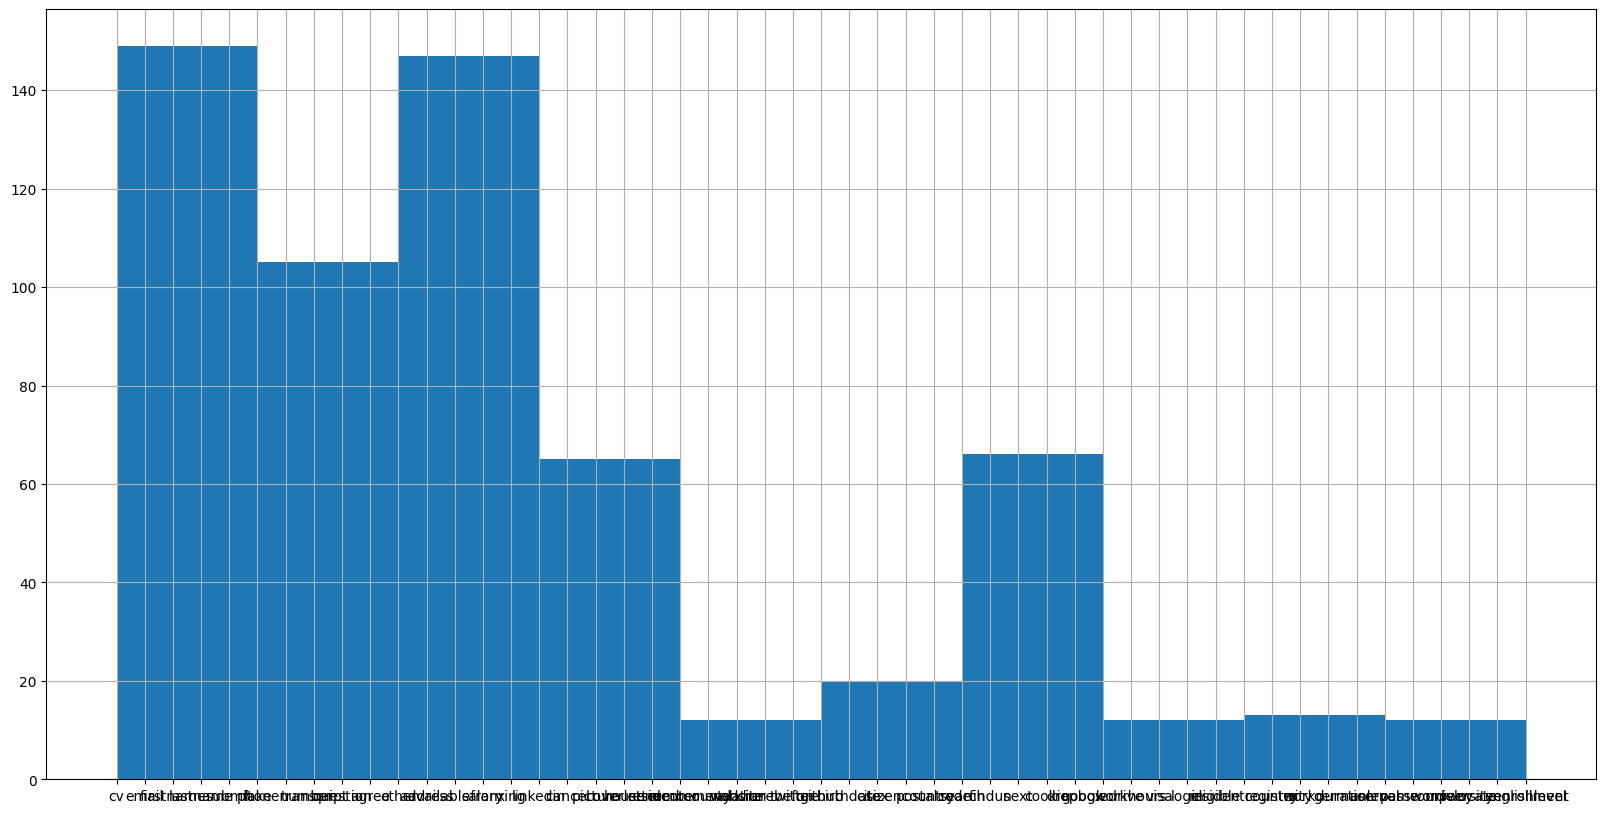

In [76]:
mydata['labels'].hist(figsize=(20,10))

In [81]:
print(mydata[(mydata['labels']!=preds) & ( mydata['labels']=='cv')]['element'].tolist())
#len(mydata[(mydata['labels']==preds)])/len(mydata)

['<input accept=".doc, .docx, .pdf, .rtf, .txt" type="file" autocomplete="off" tabindex="-1" class="fileuploader___styledinput-sc-e2002db3-0 djcsgj">', '<input class="application-file-input invisible-resume-upload" data-qa="input-resume" id="resume-upload-input" name="resume" tabindex="-1" type="file">', '<button name="button" type="button" data-source="attach" class="unstyled-button link-button" aria-describedby="resume-allowable-file-types">attach</button>', '<button name="button" type="button" data-source="paste" class="unstyled-button link-button" aria-pressed="false">or enter manually</button>', '<input type="file" class="file-input" name="az-f" id="az-f" required="" accept=".pdf,.doc,.docx,.png,.gif,.jpeg,.odt,.jpg">', '<input style="display:none;width:1px;height:1px;" data-field-name="candidate_profile.resume" id="candidate_profile.resume" class="file-upload" name="candidate_profile.resume" type="file" autocomplete="off">', '<a id="ctl00_maincontent_detailscontrol_ctl00_ctl00_xi

In [ ]:
#x = y.to_list()
hypothesis_2 = [hypothesis ]* len(y)
print(len(x) , len(hypothesis_2))

for p,h in zip(y,hypothesis_2):
    t  = tokenizer(p,h,return_tensors='pt',truncation=False,max_length=512,padding='max_length').to('cuda')
    #input_ids.append(t['input_ids'])
    #masks.append(t['attention_mask'])
    #total.append(t)
    with torch.no_grad():
        model(**t)
    breakss


    


In [ ]:
#d = {'input_ids':torch.vstack(input_ids) , 'attention_mask':torch.vstack(masks)}
#d = default_data_collator(total)
#d
input()
import torch.utils
import torch.utils.data


#d = datasets.Dataset.from_list(total)
#d = torch.utils.data.DataLoader(total,32)
#torch.utils.data.Dataset()
d

In [ ]:
#next(iter(d))['input_ids']
#d[0]['input_ids'][0]
del d
with torch.no_grad():
    for t in total:
        model(**t)
        break

#d['input_ids'].shape


In [ ]:
d['input_ids'].shape


In [ ]:
with torch.no_grad():
    for b in d:
        print(b['input_ids'].shape)
        o = model(input_ids=b['input_ids'])
        print(o.logits)
        


In [ ]:
"""pip = pipeline('zero-shot-classification',model = model,tokenizer=tokenizer,device='cuda')#pipeline_class=['email','firstname','lastname','cv'])
sequence_to_classify = mydata['element'][1]
print(sequence_to_classify)
candidate_labels = mydata['labels'].unique()
print(candidate_labels)
o = pip(sequence_to_classify, candidate_labels)

hypothesis = [f"this text is about {label}" for label in candidate_labels]
premises = [sequence_to_classify ] * len(hypothesis)
print(hypothesis)
print(premises)
tokenized_input = tokenizer(premises,hypothesis,return_tensors='pt',truncation=True,max_length=512,padding=True).to('cuda')
print(x:= tokenized_input['input_ids'][0])
print(tokenizer.convert_ids_to_tokens(x))
with torch.no_grad():
    o =  model(**tokenized_input).logits
    pass


positive_index = 2
print(candidate_labels[o.argmax(0)[positive_index]])
[ (candidate_labels[i],o[i,2].detach().cpu().numpy())for i in o.argsort(0,descending=True)[:,2] ]
"""

In [ ]:
#model = model.eval()
#input_ids = tokenizer("create an html apply button?", return_tensors='pt').to('cuda')["input_ids"]
#outputs = model.generate(input_ids, max_new_tokens=216)
#tokenizer.decode(outputs[0])

In GPT2 and Roberta tokenizers, the space before a word is part of a word, i.e. "Hello how are you puppetter" will be tokenized in ["Hello", "Ġhow", "Ġare", "Ġyou", "Ġpuppet", "ter"]. You can notice the spaces included in the words a Ġ here. Spaces are converted in a special character (the Ġ ) in the tokenizer prior to BPE splitting mostly to avoid digesting spaces since the standard BPE algorithm used spaces in its process (this can seem a bit hacky but was in the original GPT2 tokenizer implementation by OpenAI).

You probably have noted that the first word is a bit different because it’s lacking the first space but actually the model is trained like this and reach its best performances like this, with a special first word (see https://github.com/huggingface/transformers/issues/3788 194)
However, this behavior is a bit strange to some users because the first word is then different from the others: encoding Cats are super coolio and super coolio will not give the same tokenization (see here for instance: https://github.com/huggingface/transformers/issues/5249 122)
transformers thus provide an add_prefix_space argument to automatically add a space at the beginning if none is provided (more intuitive tokenization but slightly lower performances though).
The library used to have a complex mechanism to disable this when special tokens are used and control it dynamically. This mechanism was error-prone and this behavior is now simply activated or not at instantiation of the tokenizer (i.e. as an argument in from_pretrained ).
Also note that adding prefix space is necessary when the tokenizer is used with pre-tokenized inputs ( is_pretokenized=True ) the library has a test that raise an error if you want to encode some input with add_prefix_space=False : https://github.com/huggingface/transformers/blob/master/src/transformers/tokenization_gpt2.py#L364 147